In [1]:
# !pip install -qq diffusers transformers ftfy accelerate


In [2]:
import os
import torch
import math

import PIL
from PIL import Image

from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

In [3]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
SEED = 1000
torch.manual_seed(SEED)
generator = torch.Generator(device="cuda").manual_seed(SEED)

In [5]:

def image_grid(imgs, rows=1, cols=None):
    if cols is None: cols = math.ceil(len(imgs)/rows)
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
pretrained_model_name = "CompVis/stable-diffusion-v1-4"

concept_libraries = [
    "sd-concepts-library/birb-style",
    "sd-concepts-library/line-art",
    "sd-concepts-library/poolrooms",
    "sd-concepts-library/midjourney-style",
    "sd-concepts-library/depthmap",
    "sd-concepts-library/glow-forest",    
    "sd-concepts-library/style-of-marc-allante",
    "sd-concepts-library/3d-female-cyborgs",
    "sd-concepts-library/malika-favre-art-style",
    "sd-concepts-library/dan-mumford"    
]


In [7]:
#@title Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [8]:
prompt = "A cinematic hand made large wall poster of girl with red gun"
num_samples = 2 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/50 [00:00<?, ?it/s]

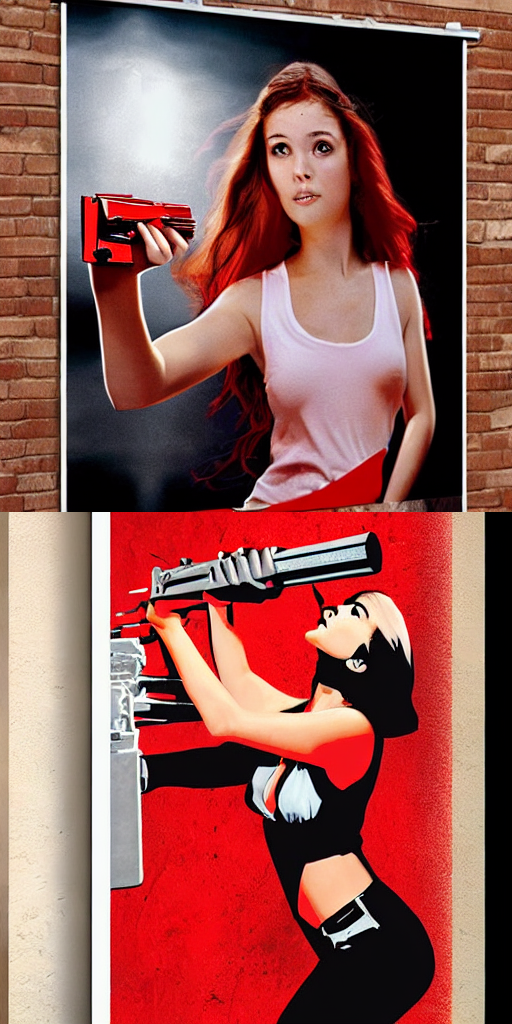

In [9]:
all_images = [] 
for _ in range(num_rows):
    images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5, generator=generator).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

In [10]:
prompt_template = "A cinematic hand made large wall poster of girl with red <TBD>"

In [11]:
all_images = [] 

for library in concept_libraries:
    # pipe.load_textual_inversion("sd-concepts-library/cat-toy")
    replacement_prompt_word = library.split("/")[1]
    prompt = prompt_template.replace("TBD", replacement_prompt_word)
    pipe.load_textual_inversion(library)
    print(prompt)
    for _ in range(num_rows):
        images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=50, guidance_scale=7.5).images
        all_images.extend(images)

A cinematic hand made large wall poster of girl with red <birb-style>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <line-art>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <poolrooms>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <midjourney-style>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <depthmap>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <glow-forest>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <style-of-marc-allante>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <3d-female-cyborgs>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <malika-favre-art-style>


  0%|          | 0/50 [00:00<?, ?it/s]

A cinematic hand made large wall poster of girl with red <dan-mumford>


  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
# grid = image_grid(all_images, rows=10)
# grid

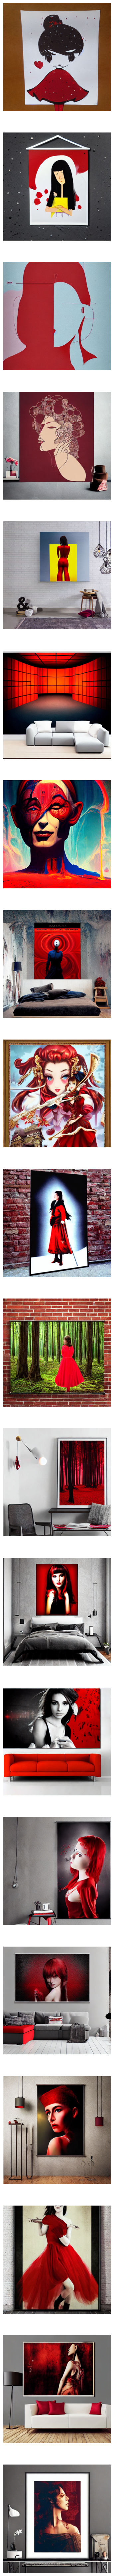

In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image_arrays = [np.array(img) for img in all_images]
fig, axes = plt.subplots(nrows=20, figsize=(15, 100))
for ax, img in zip(axes, image_arrays):
    ax.imshow(img)
    ax.axis('off')
plt.show()